## Supplementary Material to Tutorial 2

This notebook is designed for execution on Google colab. For an offline/binder version, use the version in the Notebooks folder.

In [ ]:
# this can take up to a minute or longer
!git clone --depth 1 https://github.com/dsavransky/YieldModelingWorkshopTutorial

In [ ]:
!pip install seaborn

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## SM1: Comparing Two Ensembles

We show two ensembles side-by-side to allow a direct comparison of differences in yield.

For illustration, we're using an 8m telescope to compare to the 6m telescope examined above. All other settings are the same.

The ensemble for the 8m telescope has significantly more characterizations.

In [3]:
obs_char = pd.read_csv('../Tabulations/H6C/ensemble-chars.csv')
obs_char_8m = pd.read_csv('../Tabulations/H8C/ensemble-chars.csv')
print(f'6m telescope ensemble has {len(obs_char)} chars\n8m telescope ensemble has {len(obs_char_8m)} chars\n')

6m telescope ensemble has 2289 chars
8m telescope ensemble has 2879 chars



We count the characterization yield just as before for the 6m case, by counting only the first planet in the system.

In [6]:
# stars visited for characterizations - 8m telescope
chars_stars = obs_char.loc[obs_char.plan_num==1].seed.value_counts()
chars_stars_8m = obs_char_8m.loc[obs_char_8m.plan_num==1].seed.value_counts()

Let's see how much the extra aperture has increased characterization yield. 

Plot tweak: we shrink the bandwidth of the smoothing kernel (`bw_adjust`), and thereby produce a plot closer to the underlying yield histogram.

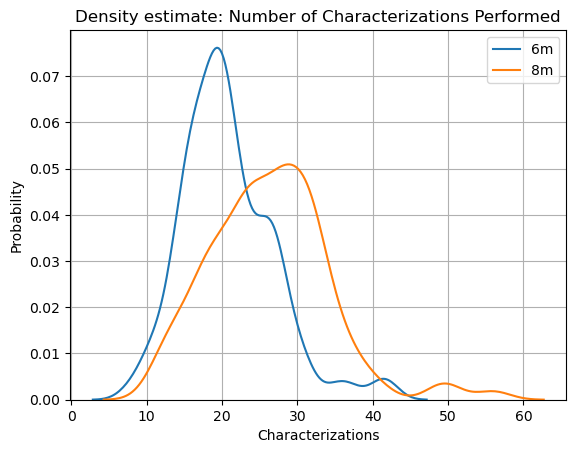

In [7]:
# smoothed versions of the yield histogram for both telescopes
sns.kdeplot(data=list(chars_stars), bw_adjust=0.7)
sns.kdeplot(data=list(chars_stars_8m), bw_adjust=0.7)
plt.title('Density estimate: Number of Characterizations Performed')
plt.xlabel('Characterizations')
plt.ylabel('Probability')
plt.legend(['6m', '8m'])
plt.grid()

Let's see what stars we are able to characterize with the bigger aperture.

Just as before, we pivot the table of characterizations to count characterizations by star name, rather than by seed and observation number.

Note that we have been able to characterize 26 more stars than previously -- the two yield tables have different index sets. (In fact, the difference is not monotonic; some stars were characterized by the 6m telescope but not by the 8m.)

In [10]:
# Star-by-star yield as a pivot table
#   (counting arrival_time is a trick to get a yield)
obs_det = pd.read_csv('../Tabulations/H6C/ensemble-dets.csv')
Nens = len(pd.unique(obs_det.seed))
yield_starname = obs_char.loc[obs_char.plan_num==1].pivot_table(values=['arrival_time', 'dist', 'luminosity'], index='Name', aggfunc={'arrival_time': 'count', 'dist':np.mean, 'luminosity': np.mean})
yield_starname = yield_starname.rename(columns={'arrival_time': 'char_count'})
# yield = (#chars) / Nens
yield_starname.insert(0, 'yield', value=yield_starname.char_count/Nens)
print(f'We observed {len(yield_starname)} unique stars - pivot table has one row per star')
yield_starname.head()
yield_starname_8m = obs_char_8m.loc[obs_char_8m.plan_num==1].pivot_table(values=['arrival_time', 'dist', 'luminosity'], index='Name', aggfunc={'arrival_time': 'count', 'dist':np.mean, 'luminosity': np.mean})
yield_starname_8m = yield_starname_8m.rename(columns={'arrival_time': 'char_count'})
# yield = (#chars) / Nens
yield_starname_8m.insert(0, 'yield', value=yield_starname_8m.char_count/Nens)
print(f'8m telescope observed {len(yield_starname_8m)} unique stars')
print(f'6m telescope observed {len(yield_starname)} unique stars')

We observed 215 unique stars - pivot table has one row per star
8m telescope observed 241 unique stars
6m telescope observed 215 unique stars


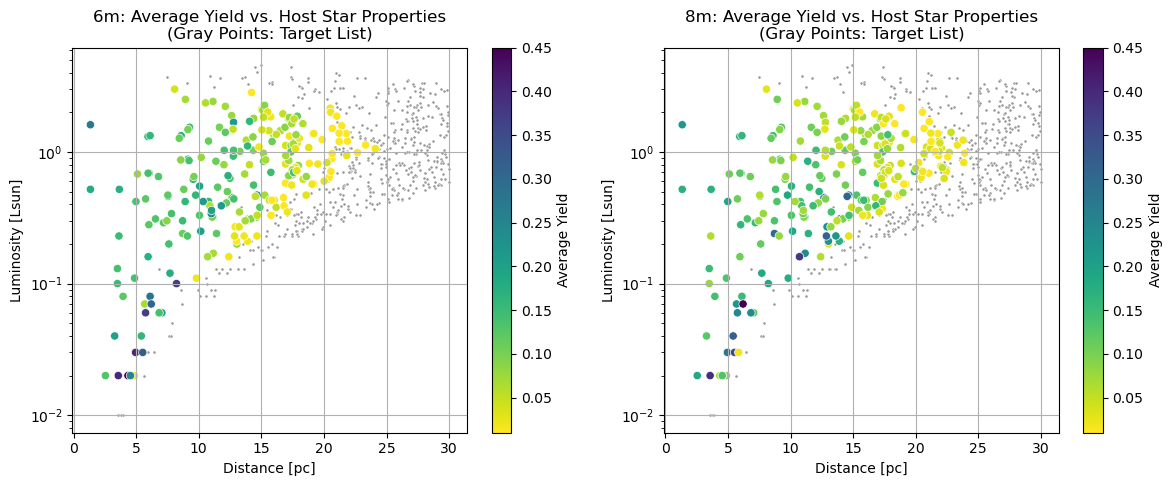

In [12]:
# Now show entire TargetList, and ensemble's yield
spc = pd.read_csv('../Tabulations/H6C/spc.csv')
fig = plt.figure(figsize=(14,5))
axs = fig.subplots(1,2)

# LHS plot: 6m Yield overlaid on Target List
sns.scatterplot(data=spc, x='dist', y='L', marker='.', color="0.6", s=20, legend=None, ax=axs[0])
# yield is from the per-star yield table, as above
sns.scatterplot(data=yield_starname, x='dist', y='luminosity', hue='yield', palette='viridis_r', ax=axs[0])
axs[0].set_title('6m: Average Yield vs. Host Star Properties\n(Gray Points: Target List)')

# RHS plot: 8m Yield overlaid on Target List
sns.scatterplot(data=spc, x='dist', y='L', marker='.', color="0.6", s=20, legend=None, ax=axs[1])
# yield is from the per-star yield table, as above
sns.scatterplot(data=yield_starname_8m, x='dist', y='luminosity', hue='yield', palette='viridis_r', ax=axs[1])
axs[1].set_title('8m: Average Yield vs. Host Star Properties\n(Gray Points: Target List)')

# settings common to both figures
for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Distance [pc]')
    ax.set_ylabel('Luminosity [Lsun]')
    ax.grid()
    # colorbar outside the plot
    sm = plt.cm.ScalarMappable(cmap="viridis_r")
    sm.set_array(yield_starname['yield'].values) # common scale
    ax.get_legend().remove()
    fig.colorbar(sm, ax=ax, label='Average Yield')



We can notice some instances of larger yield at the low-luminosity edge of the right-hand (8m) plot. 

Let's look more closely at the yield increase by combining the two tables and making a difference plot in a similar format.

In [13]:
# combine both tables, matching on the "Name" index
yield_both = pd.merge(yield_starname, yield_starname_8m, on="Name", how="outer", suffixes=("_6m", "_8m"))
# set the yield of un-matched stars to zero in both instruments
yield_both['yield_6m'] = yield_both['yield_6m'].fillna(0.0)
yield_both['yield_8m'] = yield_both['yield_8m'].fillna(0.0)
# show the attributes of the merged table
yield_both.head()

,yield_6m,char_count_6m,dist_6m,luminosity_6m,yield_8m,char_count_8m,dist_8m,luminosity_8m
Name,,,,,,,,
HIP 100017,0.15,15.0,17.57,1.18,0.07,7.0,17.57,1.18
HIP 100925,0.02,2.0,19.52,0.81,0.00,NaN,NaN,NaN
HIP 10138,0.16,16.0,10.78,0.42,0.16,16.0,10.78,0.42
HIP 101997,0.14,14.0,14.38,0.56,0.12,12.0,14.38,0.56
HIP 103096,0.20,20.0,7.05,0.06,0.14,14.0,7.05,0.06


Let's put in the yield increase as a separate attribute.

And also, clean up the scattering of `NaN` values in luminosity and distance, for those stars that appeared in only one of the two tables.

In [14]:
# new column: increase in yield for 8m over 6m
yield_both['increase'] = yield_both['yield_8m'] - yield_both['yield_6m']
# new columns: dist/luminosity, taking from 6m or 8m, whichever is valid
yield_both['dist'] = np.where(np.isfinite(yield_both['dist_6m']), yield_both['dist_6m'], yield_both['dist_8m'])
yield_both['luminosity'] = np.where(np.isfinite(yield_both['luminosity_6m']), yield_both['luminosity_6m'], yield_both['luminosity_8m'])

# rough diagnostics - these are not ensemble averages but they provide a sanity check
print(f'6m yield = {yield_both["yield_6m"].sum()}; 8m yield = {yield_both["yield_8m"].sum()}')
print(f'Yield increase = {yield_both["increase"].sum()}')

# verify what we have constructed
yield_both.head()

6m yield = 20.800000000000004; 8m yield = 26.290000000000003
Yield increase = 5.49


,yield_6m,char_count_6m,dist_6m,luminosity_6m,yield_8m,char_count_8m,dist_8m,luminosity_8m,increase,dist,luminosity
Name,,,,,,,,,,,
HIP 100017,0.15,15.0,17.57,1.18,0.07,7.0,17.57,1.18,-0.08,17.57,1.18
HIP 100925,0.02,2.0,19.52,0.81,0.00,NaN,NaN,NaN,-0.02,19.52,0.81
HIP 10138,0.16,16.0,10.78,0.42,0.16,16.0,10.78,0.42,0.00,10.78,0.42
HIP 101997,0.14,14.0,14.38,0.56,0.12,12.0,14.38,0.56,-0.02,14.38,0.56
HIP 103096,0.20,20.0,7.05,0.06,0.14,14.0,7.05,0.06,-0.06,7.05,0.06


We have noticed that some stars observed by the 6m telescope were not observed by the 8m telescope, and vice-versa. 

So, let's look at what happened to yield on a star-by-star basis.

The points in the plot below are colored by yield increase, so colors intensify moving away from the $y=x$ line.

/var/folders/m2/11pg8ytd2b32gg02912yvzzm0000gn/T/ipykernel_45248/138640396.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm, label='Yield Increase')


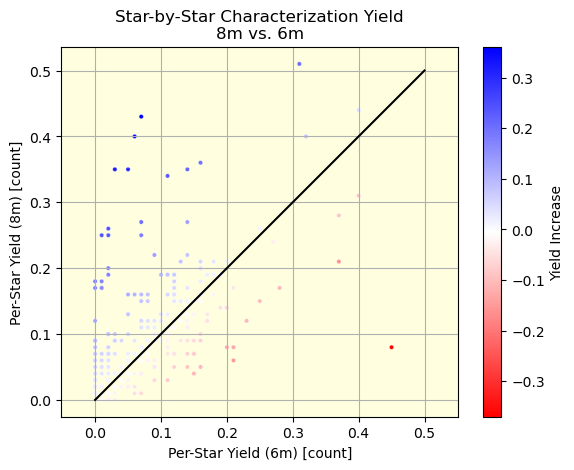

In [15]:
sns.scatterplot(data=yield_both, x='yield_6m', y='yield_8m', hue='increase', palette='bwr_r', markers='o', s=10, legend=False)
plt.plot([0, 0.5], [0, 0.5], 'k-')

ax = plt.gca()
ax.set_facecolor("lightyellow")

plt.xlabel('Per-Star Yield (6m) [count]')
plt.ylabel('Per-Star Yield (8m) [count]')
plt.title('Star-by-Star Characterization Yield\n8m vs. 6m')

plt.axis('equal')
plt.grid()

# Add the colorbar
sm = plt.cm.ScalarMappable(cmap="bwr_r")
sm.set_array(yield_both['increase'].values)
ax.figure.colorbar(sm, label='Yield Increase')

Now we can plot the same yield increase in physical coordinates, as in several of the above plots.

We can see the increase in yield for low-luminosity stars at the lower boundary of the plot, and also a fainter but definite increase for more distant stars on the right-hand side of the plot.

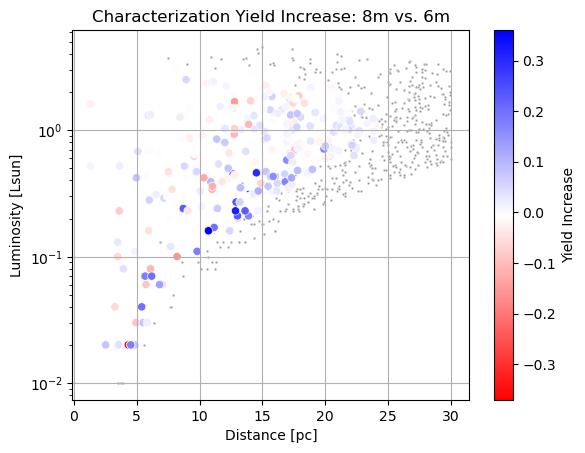

In [16]:
fig = plt.figure()
ax = plt.gca()

# Entire target list
sns.scatterplot(data=spc, x='dist', y='L', marker='.', color="0.6", s=15, legend=None)
# Only targets seen by one or the other ensemble
sns.scatterplot(data=yield_both, x='dist', y='luminosity', hue='increase', palette='bwr_r')

# plot styling
plt.yscale('log')
plt.xlabel('Distance [pc]')
plt.ylabel('Luminosity [Lsun]')
plt.title('Characterization Yield Increase: 8m vs. 6m')
plt.grid()

# colorbar outside the plot
sm = plt.cm.ScalarMappable(cmap="bwr_r")
sm.set_array(yield_both['increase'].values)
ax.get_legend().remove()
fig.colorbar(sm, ax=ax, label='Yield Increase')


## SM2: Scheduling metrics

Returning to the original 6m aperture, we show time spent on detections versus characterizations, in terms of detector integration time.

In [17]:
# per-star (not per-planet) detection observations
obs_det_star = obs_det.loc[obs_det.plan_num == 1].copy()
obs_det_g = obs_det_star.groupby('seed')
# set up DRM-by-DRM cumulative detection integration time
obs_det_star['det_time_cume'] = obs_det_g['det_time'].cumsum()


In [18]:
obs_det_star.head()

,seed,obs_num,plan_num,arrival_time,det_SNR,det_comp,det_time,det_status,WA,dMag,fEZ,Spec,Name,dist,luminosity,comp0,Mp,det_time_cume
0,10185257,5,1,1.968508,2.684593,0.532663,0.009778,0,0.180996,25.279467,3.051053e-10,G9.0V,HIP 96100,5.75,0.44,0.843450,0.561202,0.009778
1,10185257,9,1,3.996521,7.875436,0.550309,0.028771,1,0.255638,25.177009,3.559339e-09,G3V,HIP 3821 A,5.94,1.31,0.622340,1.293139,0.038549
2,10185257,27,1,14.933906,5.469566,0.566792,0.142507,0,0.114609,25.219916,1.295377e-09,G6V,HIP 29271,10.20,0.91,0.748776,0.761175,0.181055
3,10185257,28,1,15.702919,6.252488,0.529378,0.140377,0,0.089765,25.175992,6.346593e-10,G2V,HIP 15371,12.03,1.03,0.719949,0.434291,0.321432
4,10185257,30,1,16.971472,4.629985,0.670916,0.149361,0,0.177374,25.050170,1.174877e-08,G7.0V,HIP 72659 A,6.78,0.65,0.803219,0.733786,0.470793


In [21]:
# OK, find them all
int_time_binner = lambda int_times, arr_times: stats.binned_statistic(arr_times, int_times, bins=bins_missiontime)[0]
bins_missiontime = np.arange(0, 360*5, 30)
cume_det_time_hists = np.stack(list(int_time_binner(d.det_time_cume, d.arrival_time) for seed,d in obs_det_star.groupby('seed')))
print(f'The stack of histograms is Nens x Nbins: {cume_det_time_hists.shape}')

The stack of histograms is Nens x Nbins: (100, 59)


This is a cumulative plot, so it must be nondecreasing. The continuing rise in detection integration time, even as the mission time draws down, may indicate trouble scheduling characterization observations.

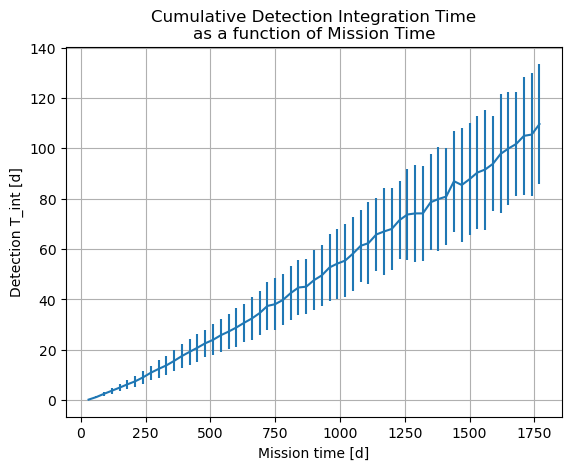

In [22]:
plt.errorbar(bins_missiontime[1:], np.nanmean(cume_det_time_hists,axis=0), np.nanstd(cume_det_time_hists, axis=0))
plt.title('Cumulative Detection Integration Time\nas a function of Mission Time')
plt.ylabel('Detection T_int [d]')
plt.xlabel('Mission time [d]')
plt.grid()

Indeed, characterizations are not being scheduled, as the plateau in characterization integration time after about 1250 days shows.

## Update: this effect is no longer really evident

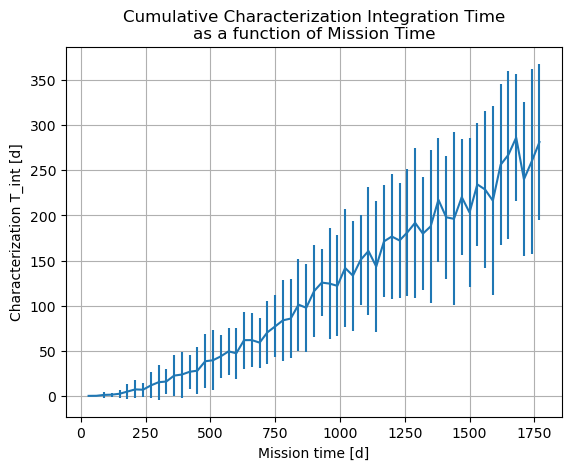

In [23]:
# per-star (not per-planet) characterization observations
obs_char_star = obs_char.loc[obs_char.plan_num == 1].copy()
obs_char_g = obs_char_star.groupby('seed')
# set up DRM-by-DRM cumulative detection integration time
obs_char_star['char_time_cume'] = obs_char_g['char_time'].cumsum()

# OK, find them all
cume_char_time_hists = np.stack(list(int_time_binner(d.char_time_cume, d.arrival_time) for seed,d in obs_char_star.groupby('seed')))

# the plot
plt.errorbar(bins_missiontime[1:], np.nanmean(cume_char_time_hists,axis=0), np.nanstd(cume_char_time_hists, axis=0))
plt.title('Cumulative Characterization Integration Time\nas a function of Mission Time')
plt.ylabel('Characterization T_int [d]')
plt.xlabel('Mission time [d]')
plt.grid()